# CARGA DE LIBRERIAS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

import torch
from torch import nn  # Modelos neuronales y funciones de Loss

from torch import optim # (3er paso BACKPROPAGATION) Optimizadores ---> Gradiente descendiente, Adam, AdaDelta, etc
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans # Modulo para construir la rbf
import math

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Elige el dispositivo. Utilizará GPU si está disponible

# LECTURA DEL DATASET

In [106]:
data = pd.read_csv('data_RBF-SOM_r9jhPOTv.csv', header=0)

In [107]:
data

,0.0,1.0,2.0,3.0,4
0,-6.968695,1.563311,-6.483773,4.243760,-1
1,3.051372,-0.143737,-3.265863,7.036494,-1
2,6.226604,1.041514,0.905390,6.631797,-1
3,-3.816713,2.169642,-7.116907,-4.210769,-1
4,-0.455559,3.931335,-5.543662,-5.179640,-1
...,...,...,...,...,...
2925,-1.940127,-2.294293,-3.686177,-2.523566,1
2926,4.252356,6.512941,3.401820,3.978096,1
2927,-1.295675,-1.210135,-2.618981,-4.128050,1
2928,1.670594,2.828671,2.484060,3.983186,1


In [108]:
counts =  data['4'].value_counts()
print(counts)

4
-1    1465
 1    1465
Name: count, dtype: int64


In [109]:
data = data.to_numpy()

**CONSIGNA 1**: Escriba el código para determinar si el dataset se encuentra balanceado, y explique los resultados obtenidos.

In [110]:
target = data[:, -1].astype(int)
target[target == -1] = 0
counts = np.bincount(target)
print(counts)

[1465 1465]


El dataset está balanceado dado que las clases tienen igual cantidad de instancias. 

## Visualización de los datos usando SOM

**CONSIGNA 2**: Entrene un modelo SOM y estime el número de clústers presente en los datos. Explique cómo llega a esa conclusión.

In [111]:
import sompy
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

In [112]:
data = data[:,:-1]
label = data[:, -1]
# NORMALIZAMOS LAS FEATURES POR COLUMNA
scaler = StandardScaler()
data = scaler.fit(X=data).transform(data)

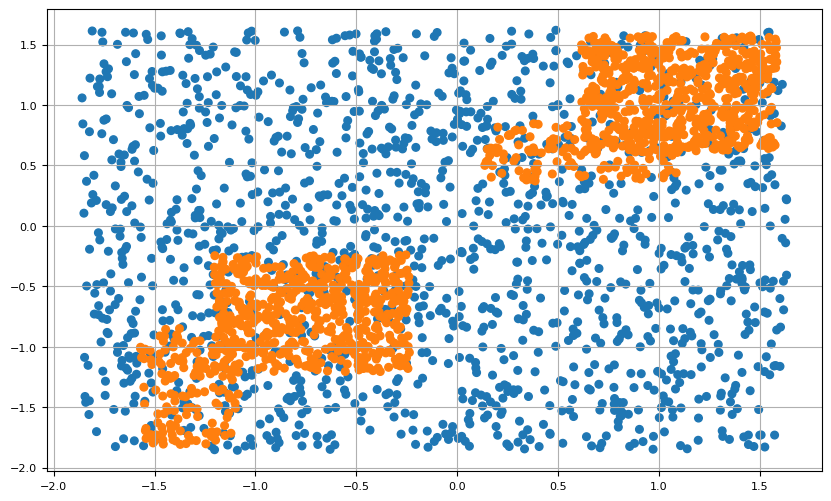

In [113]:
fig,ax = plt.subplots(1, 1, figsize=(10,6))
ax.scatter(data[:,0], data[:,1], 30, [f'C{int(i)}' for i in target], alpha=1.)
ax.grid(True);

In [114]:
mapsize = [8,8]
som = sompy.SOMFactory.build(data,
                             mapsize=mapsize,
                             mask=None,
                             mapshape='planar',
                             lattice='rect',
                             normalization='var',
                             initialization='pca',
                             neighborhood='gaussian',
                             training='batch',
                             name='sompy')

In [115]:
som.train(n_job=3,
          train_rough_len=10,
          train_rough_radiusin=5.,
          train_rough_radiusfin=1.,
          train_finetune_len=30,
          train_finetune_radiusin=1.,
          train_finetune_radiusfin=0.1,
          verbose='info')  # verbose='de

 Training...
 pca_linear_initialization took: 0.005000 seconds
 Rough training...
 radius_ini: 5.000000 , radius_final: 1.000000, trainlen: 10

 epoch: 1 ---> elapsed time:  0.081000, quantization error: 0.939010

 epoch: 2 ---> elapsed time:  0.015000, quantization error: 1.592907

 epoch: 3 ---> elapsed time:  0.014000, quantization error: 1.417572

 epoch: 4 ---> elapsed time:  0.012000, quantization error: 1.279505

 epoch: 5 ---> elapsed time:  0.016000, quantization error: 1.167017

 epoch: 6 ---> elapsed time:  0.013000, quantization error: 1.092704

 epoch: 7 ---> elapsed time:  0.011000, quantization error: 1.035341

 epoch: 8 ---> elapsed time:  0.013000, quantization error: 0.987114

 epoch: 9 ---> elapsed time:  0.016000, quantization error: 0.936894

 epoch: 10 ---> elapsed time:  0.030000, quantization error: 0.869259

 Finetune training...
 radius_ini: 1.000000 , radius_final: 0.100000, trainlen: 30

 epoch: 1 ---> elapsed time:  0.032000, quantization error: 0.779490

 

In [116]:
sompy.mapview.View2DPacked?

Init signature:
sompy.mapview.View2DPacked(
    width,
    height,
    title,
    show_axis=True,
    packed=True,
    text_size=2.8,
    show_text=True,
    col_size=6,
    *args,
    **kwargs,
)
Docstring:      <no docstring>
File:           ~/.neuralnets/lib/python3.9/site-packages/sompy/visualization/mapview.py
Type:           type
Subclasses:     

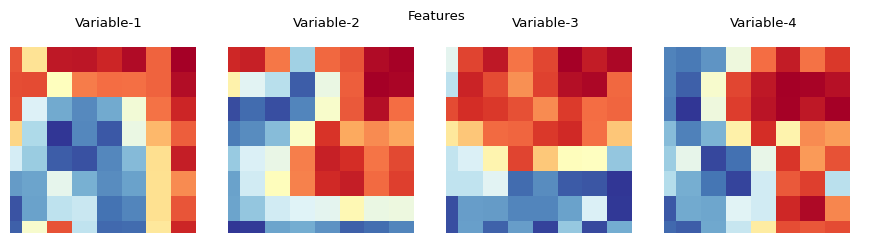

In [117]:
v = sompy.mapview.View2DPacked(mapsize[0], mapsize[1], 'Features', text_size=8)

v.show(som, what='codebook', which_dim=[0,1,2,3], cmap=None, col_sz=6) #which_dim='all' default

In [120]:
v = sompy.mapview.View2DPacked(mapsize[0], mapsize[1], 'Features', text_size=8)

#first you can do clustering. Currently only K-means on top of the trained som
cl = som.cluster(n_clusters=8)

# print cl
m = getattr(som, 'cluster_labels')
print(m.reshape(mapsize[0], mapsize[1], order='C'))

[[3 6 4 4 1 1 1 1]
 [4 4 7 5 1 1 1 1]
 [4 7 7 2 2 1 1 1]
 [4 7 7 7 6 6 1 1]
 [0 0 0 6 6 3 3 3]
 [0 0 0 0 3 3 3 3]
 [0 0 0 0 0 2 5 5]
 [0 0 0 0 0 2 5 5]]


/home/sebacastillo/.neuralnets/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


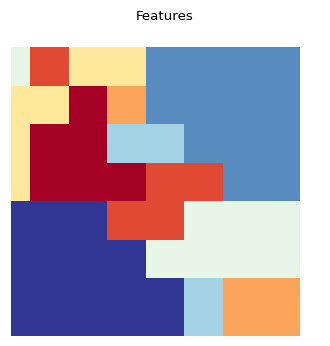

In [121]:
v.show(som, what='cluster')

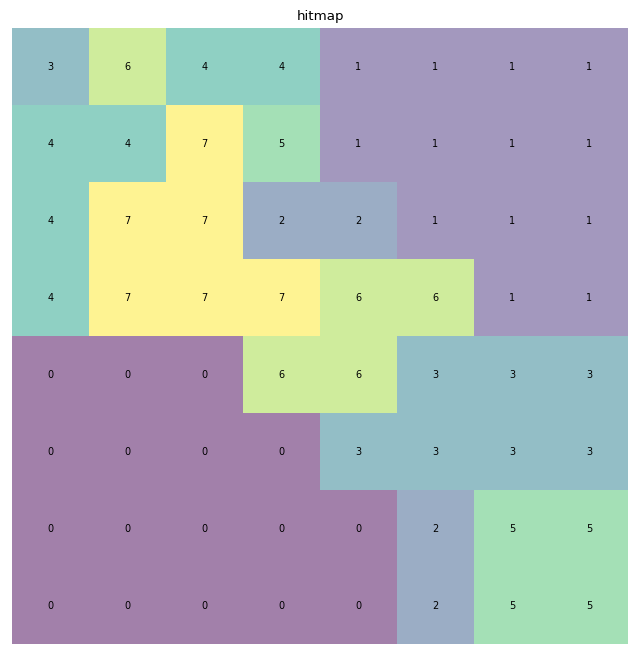

In [122]:
h = sompy.hitmap.HitMapView(mapsize[0], mapsize[1], 'hitmap', text_size=8, show_text=True)
h.show(som)

Realicé dos experimentos el primero definiendo 2 clusters y el segundo definiendo 8. En base a la distribución de datos que presenta el dataset y aunque por razones de simplificación podría pensarse en achicar el problema a 2 clusters, si aumentamos los grupos podemos ver relaciones entre los datos con mayor precision en algunos subgrupos. Esto es así pues el dataset posee datos con características muy bien definidas y datos que se encuentran en un espacio de características más bien mixtas.

## Particionado de los datos

**CONSIGNA 3**: Particiones los datos en entrenamiento, validación y test, en proporciones [65, 15, 20].
Guarde cada partición bajo los nombres ``data_trn.csv``, ``data_val.csv``,``data_tst.csv``.

**NOTA**: Los archivos deben contener 5 columnas, sin encabezado.

In [44]:
data = pd.read_csv('data_RBF-SOM_r9jhPOTv.csv', header=0)
data.head()

,0.0,1.0,2.0,3.0,4
0,-6.968695,1.563311,-6.483773,4.243760,-1
1,3.051372,-0.143737,-3.265863,7.036494,-1
2,6.226604,1.041514,0.905390,6.631797,-1
3,-3.816713,2.169642,-7.116907,-4.210769,-1
4,-0.455559,3.931335,-5.543662,-5.179640,-1


In [45]:
from sklearn.model_selection import train_test_split
X, X_tst = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)  # 80% train - 20% test
X_trn, X_val = train_test_split(X, test_size=0.3, random_state=42, shuffle=True)  # 70% train - 30% validation (esto es, sobre el 80 de arriba)

np.savetxt('data_trn.csv', X_trn, fmt='%1.4f,%1.4f,%1.4f,%1.4f,%i', delimiter=',')
np.savetxt('data_val.csv', X_val, fmt='%1.4f,%1.4f,%1.4f,%1.4f,%i', delimiter=',')
np.savetxt('data_tst.csv', X_tst, fmt='%1.4f,%1.4f,%1.4f,%1.4f,%i', delimiter=',')

# CONSTRUCCION DEL DATASET

In [63]:
class DATASET(Dataset):  # <----------------
    '''
    Esta clase maneja la lectura de los datos y provee un mecanismo
    para alimentar los modelos con los patrones.
    '''
    
    #===================================================
    def __init__(self, filename, n_clusters=10, mu=None, sigma=None):

        self.n_clusters = n_clusters
        
        #------------------------------------
        # LECTURA DE LOS DATOS
        data = pd.read_csv(filename, header=None).to_numpy() # Levanta los datos en formato numpy
        
        #------------------------------------
        # ALEATORIZO LOS PATRONES (filas)
        idxs = np.arange(len(data))  # Genero un vector de índices
        np.random.shuffle(idxs)
        data = data[idxs,:]
        
        #------------------------------------
        # SEPARO LOS DATOS
        self.x = data[:,:-1]
        Y = data[:,-1]  # La clase está en la última columna
        
        # Las clases deben ser "0" y "1"
        Y[Y == -1] = 0
        self.y = Y

        #------------------------------------
        # APLICAMOS LA TRANSFORMACIÓN CON RBF
        if (mu is None):       # Si no se ha recibido un rbf se debe entrenar una
            
            kmedias = KMeans(n_clusters=n_clusters, n_init='auto')
            rbf = kmedias.fit(self.x)
            
            cluster = rbf.predict(self.x) # Indica el cluster de pertenencia de cada patrón
            
            self.mu = np.zeros((n_clusters, self.x.shape[1]))
            sigma = np.zeros((n_clusters, self.x.shape[1]))
    
            for i in range(n_clusters): # se calculan parámetros de las guassianas
                self.mu[i,:] = self.x[cluster==i,:].mean(axis=0)  # Calculo la media
                sigma[i,:] = self.x[cluster==i,:].std(axis=0)  # Calculo la varianza
    
            self.sigma = sigma.mean(axis=1)
            
        else:
            self.mu = mu.copy()
            if (sigma is None):  # Suponemos Varianza = 1
                self.sigma = 1.
            else:
                self.sigma = sigma.copy()

    #===================================================
    def __len__(self):
        '''
        Devuelve el número de patrones en el dataset.
        '''
        return len(self.x)
    
    
    #===================================================
    def __getitem__(self, idx):
        '''
        Devuelve el/los patrones indicados.
        '''
        x = self.x[idx,:]
        y = self.y[idx]

        D = (((x - self.mu)**2).sum(axis=1))  # Distancia del patrón a cada centroide
        
        x_transf = np.exp(-D**0.5 / (2 * self.sigma))  # Transformo el patrón
        
        return x_transf.astype(np.float32), y.astype(np.float32)

# CONSTRUCCION DEL MODELO

## PERCEPTRON SIMPLE

In [64]:
class MODELO(nn.Module):  # <----------------------------

    #====================================
    def __init__(self, n_features, n_outputs):
        '''
        Esta función inicializa/construye el perceptrón.
        n_features: features de cada patrón (2 para OR y XOR)
        n_outputs: cantidad de salidas esperadas.
        '''
        
        super().__init__()
        
        self.n_features = n_features
        self.n_outputs = n_outputs
        
        self.layer1 = nn.Linear(self.n_features, self.n_outputs, bias=True)

    #====================================
    def forward(self, x):
        '''
        Esta función realiza la pasada hacia adelante.
        '''
        
        # Calculo salida lineal de la capa 1
        y = self.layer1(x)

        return y

# LOOPS

## ENTRENAMIENTO

In [65]:
def train_step(model, data, loss_function, optimizer, device):
    
    model.train()  # Calcula gradientes
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    #==============================================================
    for idx,(X,y) in enumerate(data):

        #-----------------------------------------------------
        # Convierto los datos en tensores diferenciables
        #-----------------------------------------------------
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()  # Se limpia el caché del optimizador
        
        #----------------
        # Forward pass
        #----------------
        y_pred = model(X)

        #----------------
        # Compute Loss
        #----------------
        if (data.batch_size == 1):
            loss = loss_function(y_pred.squeeze(), y.squeeze())
        else:
            loss = loss_function(y_pred.squeeze(), y)
        
        error += loss.item()
        
        #----------------
        # Backward pass
        #----------------
        loss.backward()
        optimizer.step()
    #==============================================================
    
    error /= N_batches
    
    return error, model

## VALIDACION / TEST

In [66]:
def predict_step(model, data, loss_function, device):
    
    model.eval()  # Turn off Dropouts Layers, BatchNorm Layers etc
    
    N_batches = len(data)  # Número de batches = N_patrones/N_patrones_x_batch
    
    error = 0
    
    Y = torch.tensor([])
    Yp = torch.tensor([])
    
    #==============================================================
    with torch.no_grad():  # Turn off gradients computation
        
        for idx,(X,y) in enumerate(data):

            Y = torch.hstack( (Y, y.flatten()) )

            #-----------------------------------------------------
            # Convierto los datos en tensores diferenciables
            #-----------------------------------------------------
            X = X.to(device)
            y = y.to(device)

            #----------------
            # Forward pass
            #----------------
            y_pred = model(X)
            
            Yp = torch.hstack( (Yp, y_pred.flatten().cpu()) )

            #----------------
            # Compute Loss
            #----------------
            loss = loss_function(y_pred.squeeze(), y.squeeze())

            error += loss.item()
    #==============================================================
    
    error /= N_batches
    
    #------------------
    
    return error, Y, Yp

# EXPERIMENTO

**CONSIGNA 4**: Selecciones los valores de los siguientes parámetros para entrenar el modelo:
- `learning_rate` 
- `MAX_EPOCAS`
- `MAX_COUNTER`
- `BATCH_SIZE`
- `N_CLUSTERS`

Justifique en cada caso la elección del valor. 

Aumenté número de épocas de 50 a 200 para disponer de mayor ajuste del modelo. Aumenté el batch size a 100 para que haya más patrones por iteración de entrenamiento. Aumenté el número de cluster a 8 para dar más complejidad al modelo y que pueda capturar la distribución más atomizada que presentan los datos. Los demás parámetros los dejé como estaban.

In [67]:
#=================================
# Definimos los archivos de datos
#=================================
filename_train_data = 'data_trn.csv'
filename_validation_data = 'data_val.csv'
filename_test_data = 'data_tst.csv'


#==========================================
# Inicializamos parámetros del experimento
#==========================================
learning_rate = 0.001

acc = 0.  # Inicializo el accuracy inicial
epoca = 0  # Inicializo contador de épocas

MIN_ERROR = 1     # Inicializo la variable para
                  # registrar el mínimo error cometido.
    
MAX_EPOCAS = 200  # Aumento numero de èpocas
                  # de entrenamiento.

MAX_COUNTER = 10  # Defino el máximo número de épocas
                  # sin mejorar el error de validación
                  # para detener el entrenamiento.

BATCH_SIZE = 100   # 100 aumento batch para tener más información en el entrenamiento


N_CLUSTERS = 8    # aumento número de cluster para poder modelar una distribución más compleja

#===========================================================
# Construimos los datasets para entrenamiento y validación
#===========================================================
trn = DATASET(filename_train_data, n_clusters=N_CLUSTERS, mu=None, sigma=None)
val = DATASET(filename_validation_data, n_clusters=trn.n_clusters, mu=trn.mu, sigma=trn.sigma)


#=============================================================
# Construimos los dataloaders para entrenamiento y validación
#=============================================================
train_data = DataLoader(trn, batch_size=BATCH_SIZE, shuffle=True)
validation_data = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)


#=============================================
# Inicializamos el modelo
#=============================================
modelo = MODELO(n_features=trn.n_clusters, n_outputs=1)


#=============================================
# Definimos la función de LOSS a utilizar
#=============================================
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

#=============================================
# Definimos el optimizador a utilizar
# >>> 3er paso del bacpropagation
#=============================================
optimizer = optim.SGD(modelo.parameters(), lr=learning_rate, momentum=0.9)
#optimizer = optim.Adam(modelo.parameters(), lr=learning_rate)

**CONSIGNA 5**: ¿Cuántos parámetros entrenable posee su modelo neuronal? Justifique

Tiene 25: mu y sigma para definir cada gaussiana, mas W0 x 8 para conectar cada salida de la gaussiana con la neurona de final y un parámetro adicional del bias.

## ENTRENAMIENTO DEL MODELO

In [68]:
TRN_error = []  # Inicializo estructura para almacenar
                # los errores en el tiempo
VAL_error = []  # Inicializo estructura para almacenar
                # los errores en el tiempo
accuracy = []  # Inicializo estructura para almacenar
               # el accuracy en el tiempo

STOP = False
counter = 0

best_model = None
best_model_weights = None
best_epoca = 0
best_acc = 0

#===============================================================
while (epoca < MAX_EPOCAS) and (not STOP):

    epoca += 1
    
    #----------------------
    # ENTRENAMIENTO
    #----------------------
    trn_error,modelo = train_step(modelo, train_data, loss_function, optimizer, device)
    
    #----------------------
    # VALIDACION
    #----------------------
    val_error,Y,Yp = predict_step(modelo, validation_data, loss_function, device)

    # Calculo del accuracy
    Y_pred = torch.sigmoid(Yp)
    Y_pred[Y_pred < 0.5] = 0
    Y_pred[Y_pred > 0] = 1
    acc = torch.sum(Y_pred == Y)/ len(Y)
    
    #----------------------
    # ALMACENO MEDIDAS
    #----------------------
    TRN_error.append(trn_error)
    VAL_error.append(val_error)
    accuracy.append(acc)
    
    #-----------------------------------------------
    # CRITERIO DE CORTE Y ALMACENAMIENTO DEL MODELO
    #-----------------------------------------------
    if (val_error < MIN_ERROR):
        best_epoca = epoca
        MIN_ERROR = val_error
        best_acc = acc
        counter = 0
        
        #·······················
        # Almaceno el modelo
        #·······················
        best_model = deepcopy(modelo)  # Genero una copia independiente
        best_model_weights = best_model.state_dict()
        
    else:
        counter += 1
        if counter > MAX_COUNTER:
            STOP = True
    
    #--------------------------------------------
    # MUESTRO REPORTE POR PANTALLA (POR EPOCA)
    #--------------------------------------------
    if (epoca % 10) == 0:
        print(f'Epoca: {epoca} -- Error: {val_error:.4}\t--\tTasa acierto [train]: {acc:.4}\n')
#===============================================================

#--------------------------------------------
# MUESTRO REPORTE POR PANTALLA (FINAL)
#--------------------------------------------
print('='*79)
print(f'FINAL -- Epoca: {best_epoca} -- Error: {MIN_ERROR:.4}\t--\tTasa acierto [train]: {best_acc:.4}')
print('='*79)

#-----------------------------
# GUARDO MEJOR MODELO A DISCO
#-----------------------------
torch.save(best_model,
           'best_model.pt',
           _use_new_zipfile_serialization=True)
        
#----------------------------------------------
# GUARDAMOS LOS PESOS DEL MEJOR MODELO A DISCO
#----------------------------------------------
torch.save(best_model.state_dict(),
           'best_model_state_dict.pt',
           _use_new_zipfile_serialization=True)

Epoca: 10 -- Error: 0.6718	--	Tasa acierto [train]: 0.4901

Epoca: 20 -- Error: 0.6641	--	Tasa acierto [train]: 0.5312

Epoca: 30 -- Error: 0.6571	--	Tasa acierto [train]: 0.625

Epoca: 40 -- Error: 0.6503	--	Tasa acierto [train]: 0.7173

Epoca: 50 -- Error: 0.6437	--	Tasa acierto [train]: 0.8466

Epoca: 60 -- Error: 0.6372	--	Tasa acierto [train]: 0.9105

Epoca: 70 -- Error: 0.6308	--	Tasa acierto [train]: 0.9247

Epoca: 80 -- Error: 0.6244	--	Tasa acierto [train]: 0.9361

Epoca: 90 -- Error: 0.6182	--	Tasa acierto [train]: 0.9389

Epoca: 100 -- Error: 0.6121	--	Tasa acierto [train]: 0.9403

Epoca: 110 -- Error: 0.6061	--	Tasa acierto [train]: 0.9418

Epoca: 120 -- Error: 0.6002	--	Tasa acierto [train]: 0.9432

Epoca: 130 -- Error: 0.5944	--	Tasa acierto [train]: 0.9432

Epoca: 140 -- Error: 0.5886	--	Tasa acierto [train]: 0.9489

Epoca: 150 -- Error: 0.583	--	Tasa acierto [train]: 0.9531

Epoca: 160 -- Error: 0.5775	--	Tasa acierto [train]: 0.9517

Epoca: 170 -- Error: 0.5721	--	Tasa

## GRAFICAMOS LAS SALIDAS

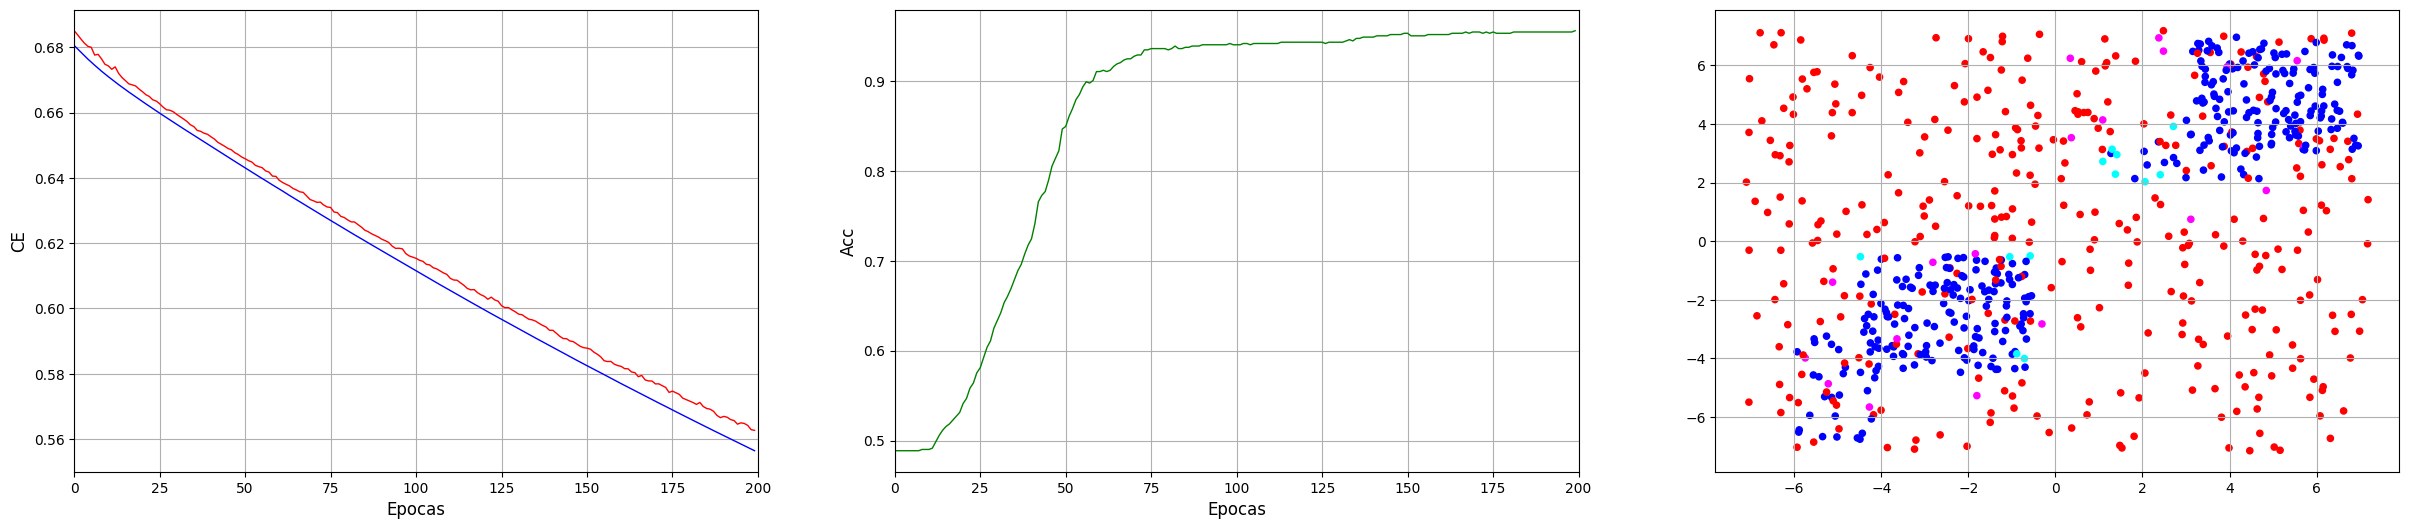

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(30,6))

epocas = np.arange(epoca)

# ERROR
ax[0].plot(epocas, TRN_error, '-r', lw=1, label='Train')
ax[0].plot(epocas, VAL_error, '-b', lw=1, label='Validation')
ax[0].grid(True)
ax[0].set_xlim(0,MAX_EPOCAS)
ax[0].set_xlabel('Epocas', fontsize=12)
ax[0].set_ylabel('CE', fontsize=12)

# ACC
ax[1].plot(epocas, accuracy, '-g', lw=1)
ax[1].grid(True)
ax[1].set_xlim(0,MAX_EPOCAS)
ax[1].set_xlabel('Epocas', fontsize=12)
ax[1].set_ylabel('Acc', fontsize=12)

# CLASIFICACION

C = []
for i in range(len(Y)):
    
    if (Y[i] == Y_pred[i]) and (Y[i] == 1):
        C.append('blue')
    if (Y[i] == Y_pred[i]) and (Y[i] == 0):
        C.append('red')
    if (Y[i] != Y_pred[i]) and (Y[i] == 1):
        C.append('cyan')
    if (Y[i] != Y_pred[i]) and (Y[i] == 0):
        C.append('magenta')
        
ax[2].scatter(validation_data.dataset.x[:,0], validation_data.dataset.x[:,1], 20, C)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ax[2].grid(True)

**CONSIGNA 6**: Obtenga el valor de la medida $F_{1}$ para los datos de validación.

In [70]:
from sklearn.metrics import f1_score
f1 = f1_score(Y, Y_pred)
print("F1-score:", f1)

F1-score: 0.9553956834532374


---

## LECTURA DE DATOS DE EVALUACION

In [71]:
#=====================================
# LEVANTAMOS DE DISCO EL MEJOR MODELO
#=====================================

del modelo  # Eliminamos de memoria
            # para asegurarnos de usar
            # el modelo guardado en disco

#--------------------------------------
# Modelo completo (archivo binario)
#--------------------------------------
modelo = torch.load('best_model.pt')

#-----------------------
# A partir de los pesos
#-----------------------
#best_model = torch.load('best_model_state_dict.pt')
#modelo = PERCEPTRON(n_features=2, lr=learning_rate)
#modelo.load_state_dict(best_model)
#modelo.to(device)

In [72]:
#=====================================
# CONSTRUIMOS EL DATASET PARA TEST
#=====================================
tst = DATASET(filename_test_data, n_clusters=trn.n_clusters, mu=trn.mu, sigma=trn.sigma)

test_data = DataLoader(tst, batch_size=BATCH_SIZE, shuffle=False)

#=====================================
# EVALUAMOS EL MODELO ENTRENADO
#=====================================
error,Y,Yp = predict_step(modelo, test_data, loss_function, device)
# TRANSFORMO SALIDA EN {0,1}
Y_pred = torch.sigmoid(Yp)
Y_pred[Y_pred < 0.5] = 0
Y_pred[Y_pred > 0] = 1

acc = torch.sum(Y_pred == Y)/ len(Y)

print('\nTasa acierto [test]: {}\n'.format(acc))


Tasa acierto [test]: 0.9590443968772888



## GRAFICAMOS LAS SALIDAS

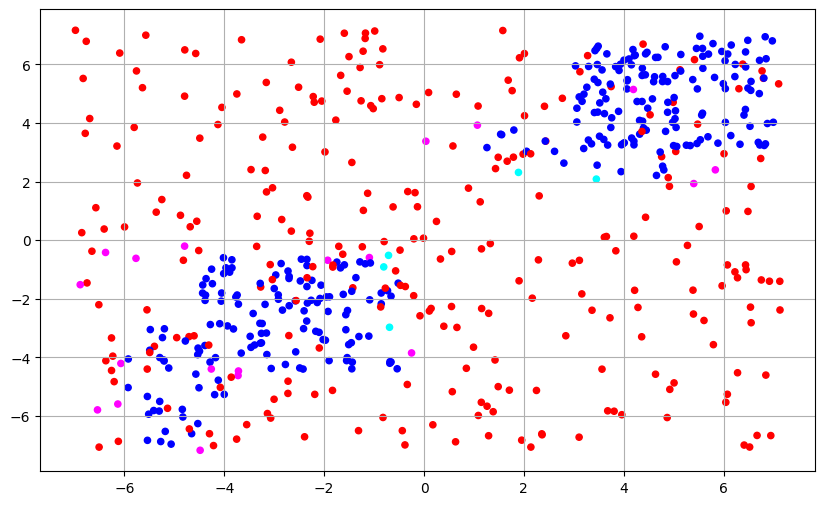

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))

C = []
for i in range(len(Y)):
    
    if (Y[i] == Y_pred[i]) and (Y[i] == 1):
        C.append('blue')
    if (Y[i] == Y_pred[i]) and (Y[i] == 0):
        C.append('red')
    if (Y[i] != Y_pred[i]) and (Y[i] == 1):
        C.append('cyan')
    if (Y[i] != Y_pred[i]) and (Y[i] == 0):
        C.append('magenta')
        
ax.scatter(test_data.dataset.x[:,0], test_data.dataset.x[:,1], 20, C)  # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
ax.grid(True)

**CONSIGNA 7**: Construya la matriz de confusión para los resultados de test, y analice los resultados obtenidos. Qué puede concluir de con estos valores?

In [74]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y, Y_pred)
cm

array([[274,  19],
       [  5, 288]])

La matriz está señalando que el modelo clasifica correctamente ambas clases en una proporción de .95, y que el error se distribuye en principio de manera homegénea entre ambas. 